# Assignment 1 2AMM10 2023-2024

## Group: [Group ]
### Member 1: [Jasper Wilfling]
### Member 2: [Justin Habets]
### Member 3: [Thijmen Adriaansen]

In [3]:
!pip install kagglehub

In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
from torchvision import transforms
import kagglehub
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from collections import defaultdict
import torch.nn.functional as F
from torch.utils.data.sampler import BatchSampler
from itertools import combinations
from sklearn.metrics import balanced_accuracy_score
from collections import Counter

# add additonal imports here
class FashionDataset(Dataset):
    def __init__(self, csv_file, img_dir,column_class="articleTypeId", transform=None):
        """
        Args:
            csv_file (str): Path to the CSV file with labels.
            img_dir (str): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.df = pd.read_csv(csv_file)  # load CSV file
        self.img_dir = img_dir  # image folder path
        self.transform = transform  # image transformations
        self.targets = list(self.df[column_class].values)


    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, f"{self.df.loc[idx,'imageId']}.jpg")  # Get image filename
        image = Image.open(img_name).convert("RGB")  # Load image

        if self.transform:
            image = self.transform(image)  # Apply transformations

        return image, self.targets[idx]

Download data with kagglehub

In [2]:
dataset_path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-small")
img_dir = os.path.join(dataset_path,"images")

100%|███████████████████████████████████████████████████████████████████████████████| 565M/565M [03:07<00:00, 3.16MB/s]

Extracting files...


The different datasets can be loaded using the class `FashionDataset` which is a custon PyTorch dataset (see [Datasets & DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) for more information). Below an example of how to use the `FashionDataset` constructor as well as some visualizations. Please note that you may have to adapt the arguments to match the strucucture of your working directory.

In [3]:
dataset = FashionDataset("dataset/train.csv",img_dir)

In [4]:
dataset.df.head()

,imageId,articleTypeName,categoryName,articleTypeId,categoryId
0,35180,Backpacks,Bags,15,2
1,33585,Tshirts,Topwear,0,0
2,9464,Shirts,Topwear,1,0
3,8194,Shirts,Topwear,1,0
4,42231,Tops,Topwear,6,0


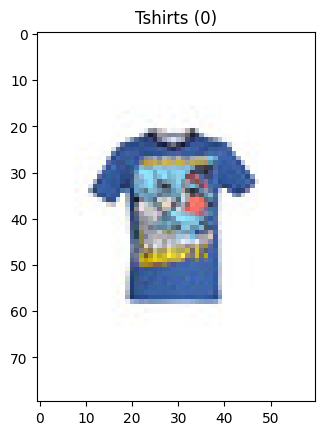

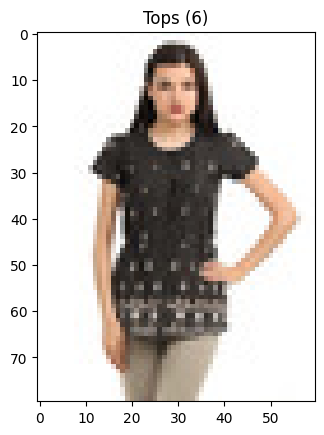

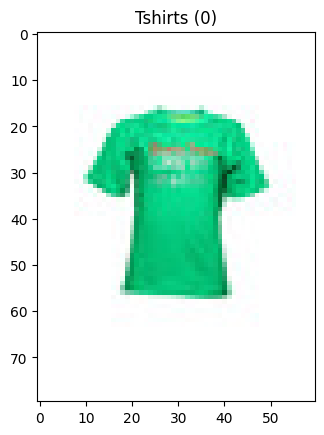

In [5]:
np.random.seed(42)
random_indices = np.random.choice(len(dataset),3) # randomly select 3 indices

for i in random_indices:
    img, label = dataset[i]
    plt.title(dataset.df.iloc[i]["articleTypeName"]+f" ({label.item()})")
    plt.imshow(img)
    plt.show()

## Loading different datasets

In [6]:
transform = transforms.Compose([
    transforms.Resize((80, 60)),  # Ensure consistent size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
train_dataset = FashionDataset("dataset/train.csv",img_dir,transform=transform)
main_test_dataset =  FashionDataset("dataset/main_test.csv",img_dir,transform=transform)
new_test_dataset =  FashionDataset("dataset/new_test.csv",img_dir,transform=transform)
main_support_dataset =  FashionDataset("dataset/main_support.csv",img_dir,transform=transform)
new_support_dataset =  FashionDataset("dataset/new_support.csv",img_dir,transform=transform)
merged_test_dataset =  FashionDataset("dataset/merged_test.csv",img_dir,transform=transform) # merged corresponds to main+new
merged_support_dataset =  FashionDataset("dataset/merged_support.csv",img_dir,transform=transform)

# datasets with categories
main_test_dataset_cat =  FashionDataset("dataset/main_test.csv",img_dir,column_class="categoryId",transform=transform)
main_support_dataset_cat =  FashionDataset("dataset/main_support.csv",img_dir,column_class="categoryId",transform=transform)


label_id_to_label_name = {i: train_dataset.df[train_dataset.df["articleTypeId"]==i]["articleTypeName"].iloc[0] for i in range(39)}
label_id_to_label_name.update({i: new_test_dataset.df[new_test_dataset.df["articleTypeId"]==i]["articleTypeName"].iloc[0] for i in range(39,39+30)})

## Task 1

In [8]:
# your solution
# train dataset: train_dataset
# test datset: main_test_dataset

# Create dataloader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define the CNN model
class FashionCNN(nn.Module):
    def __init__(self, num_classes=39):
        super(FashionCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 30x40
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 15x20
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 7x10
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 7 * 10, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        return self.classifier(x)


In [9]:
# Instantiate model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = FashionCNN(num_classes=39).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1}, Average Loss: {running_loss / len(train_loader):.4f}")

torch.save(model.state_dict(), "task_1.pth")

Using device: cuda


Epoch 1/10: 100%|██████████| 562/562 [02:58<00:00,  3.15it/s, loss=0.448]


Epoch 1, Average Loss: 1.0294


Epoch 2/10: 100%|██████████| 562/562 [00:49<00:00, 11.41it/s, loss=0.366]


Epoch 2, Average Loss: 0.5243


Epoch 3/10: 100%|██████████| 562/562 [00:48<00:00, 11.66it/s, loss=0.691]


Epoch 3, Average Loss: 0.4229


Epoch 4/10: 100%|██████████| 562/562 [00:47<00:00, 11.71it/s, loss=0.209]


Epoch 4, Average Loss: 0.3493


Epoch 5/10: 100%|██████████| 562/562 [00:50<00:00, 11.17it/s, loss=0.238]


Epoch 5, Average Loss: 0.3062


Epoch 6/10: 100%|██████████| 562/562 [00:50<00:00, 11.23it/s, loss=0.256]


Epoch 6, Average Loss: 0.2606


Epoch 7/10: 100%|██████████| 562/562 [00:50<00:00, 11.19it/s, loss=0.228]


Epoch 7, Average Loss: 0.2277


Epoch 8/10: 100%|██████████| 562/562 [00:49<00:00, 11.36it/s, loss=0.0682]


Epoch 8, Average Loss: 0.1867


Epoch 9/10: 100%|██████████| 562/562 [00:48<00:00, 11.47it/s, loss=0.132]


Epoch 9, Average Loss: 0.1680


Epoch 10/10: 100%|██████████| 562/562 [00:52<00:00, 10.77it/s, loss=0.161]

Epoch 10, Average Loss: 0.1506


In [10]:
# Evaluation on test dataset
test_loader = DataLoader(main_test_dataset, batch_size=64, shuffle=False)

def evaluate_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    class_correct = defaultdict(int)
    class_total = defaultdict(int)

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            for label, pred in zip(labels, preds):
                class_total[label.item()] += 1
                if pred.item() == label.item():
                    class_correct[label.item()] += 1

    # Accuracy
    accuracy = correct / total

    # Balanced accuracy
    all_classes = list(class_total.keys())
    balanced_acc = sum(class_correct[c] / class_total[c] for c in all_classes) / len(all_classes)

    return accuracy, balanced_acc

accuracy, balanced_acc = evaluate_model(model, test_loader, device)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Balanced Accuracy: {balanced_acc:.4f}")


Test Accuracy: 0.8933
Test Balanced Accuracy: 0.8442


## Task 2

In [ ]:
# your solution
# train dataset: train_dataset
# test and support dataset: see scenarios table

In [10]:
class EmbeddingFashionCNN(nn.Module):
    def __init__(self, embedding_dim=39):
        super(EmbeddingFashionCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 30x40
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 15x20
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 7x10
        )
        self.embedding = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 7 * 10, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, embedding_dim)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.embedding(x)
        x = F.normalize(x, p=2, dim=1)  # L2 normalize embeddings
        return x

In [11]:
class BalancedBatchSampler(BatchSampler):
    """
    Returns batches of size n_classes * n_samples
    """

    def __init__(self, labels, n_classes, n_samples):
        self.labels = labels
        self.labels_set = list(set(self.labels))
        self.label_to_indices = {label: np.where(  np.array(self.labels) == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.n_dataset = len(self.labels)
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < self.n_dataset:
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return self.n_dataset // self.batch_size

In [12]:
class RandomTripletSelector():
    """
    Select random negative  example for  each positive pair  to create triplets
    """

    def __init__(self):
        super(RandomTripletSelector, self).__init__()

    def get_triplets(self, embeddings, labels):
        labels = labels.cpu().data.numpy()
        triplets = []
        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs

            # random choose one negative example for each positive pair
            temp_triplets = [[anchor_positive[0], anchor_positive[1], np.random.choice(negative_indices)] for anchor_positive in anchor_positives]
            triplets += temp_triplets

        return torch.LongTensor(np.array(triplets))

In [13]:
class TripletLoss(nn.Module):
    """
    Triplets loss
    Takes a batch of embeddings and corresponding labels.
    Triplets are generated using triplet_selector object that take embeddings and targets and return indices of
    triplets
    """

    def __init__(self, margin, triplet_selector):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.triplet_selector = triplet_selector

    def forward(self, embeddings, target):

        triplets = self.triplet_selector.get_triplets(embeddings, target)

        if embeddings.is_cuda:
            triplets = triplets.cuda()


        anchor_idx= triplets[:, 0]
        positive_idx= triplets[:, 1]
        negative_idx= triplets[:, 2]


        ap_distances = (embeddings[anchor_idx] - embeddings[positive_idx]).pow(2).sum(1)  # .pow(.5)
        an_distances = (embeddings[anchor_idx] - embeddings[negative_idx]).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(ap_distances - an_distances + self.margin)

        return losses.mean()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Instantiate model and move to device
model = EmbeddingFashionCNN().to(device)

# Define loss function, optimizer, and learning rate scheduler
triplet_loss = TripletLoss(margin=1, triplet_selector=RandomTripletSelector()).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

# DataLoader setup using BalancedBatchSampler
train_batch_sampler = BalancedBatchSampler(train_dataset.targets, n_classes=10, n_samples=5)
train_loader = DataLoader(train_dataset, batch_sampler=train_batch_sampler)


# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Wrap the train_loader with tqdm to show progress
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=True):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass: Get embeddings
        embeddings = model(images)

        # Compute triplet loss
        loss = triplet_loss(embeddings, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    # Step the scheduler using training loss
    scheduler.step(epoch_loss)

# Save the trained model
torch.save(model.state_dict(), "task_2.pth")

Epoch 1/10: 100%|██████████| 718/718 [00:55<00:00, 12.94it/s]


Epoch [1/10], Loss: 0.1940


Epoch 2/10: 100%|██████████| 718/718 [00:56<00:00, 12.62it/s]


Epoch [2/10], Loss: 0.1029


Epoch 3/10: 100%|██████████| 718/718 [00:55<00:00, 13.00it/s]


Epoch [3/10], Loss: 0.0889


Epoch 4/10: 100%|██████████| 718/718 [00:58<00:00, 12.24it/s]


Epoch [4/10], Loss: 0.0737


Epoch 5/10: 100%|██████████| 718/718 [00:56<00:00, 12.72it/s]


Epoch [5/10], Loss: 0.0666


Epoch 6/10: 100%|██████████| 718/718 [00:53<00:00, 13.48it/s]


Epoch [6/10], Loss: 0.0617


Epoch 7/10: 100%|██████████| 718/718 [00:52<00:00, 13.64it/s]


Epoch [7/10], Loss: 0.0534


Epoch 8/10: 100%|██████████| 718/718 [00:52<00:00, 13.66it/s]


Epoch [8/10], Loss: 0.0523


Epoch 9/10: 100%|██████████| 718/718 [00:53<00:00, 13.52it/s]


Epoch [9/10], Loss: 0.0542


Epoch 10/10: 100%|██████████| 718/718 [00:52<00:00, 13.64it/s]

Epoch [10/10], Loss: 0.0469


In [16]:
#import model
model = EmbeddingFashionCNN(embedding_dim=39).to(device)
model.load_state_dict(torch.load("task_2.pth"))
model.to(device)

def extract_embeddings(model, dataloader, device):
    model.eval()
    all_embeddings = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            embeddings = model(images)  # embeddings already normalized inside model
            all_embeddings.append(embeddings.cpu())
            all_labels.append(labels)

    all_embeddings = torch.cat(all_embeddings)
    all_labels = torch.cat(all_labels)

    return all_embeddings, all_labels

def knn_classify(test_embeddings, support_embeddings, support_labels, k=5):
    """
    Classify test embeddings using k-NN with support embeddings and labels.
    """
    # Compute pairwise Euclidean distances: shape (N_test, N_support)
    distances = torch.cdist(test_embeddings, support_embeddings)

    preds = []
    for dist_vec in distances:
        knn_indices = dist_vec.topk(k, largest=False).indices  # Indices of k nearest neighbors
        knn_labels = support_labels[knn_indices]
        most_common = Counter(knn_labels.tolist()).most_common(1)[0][0]
        preds.append(most_common)

    return torch.tensor(preds)

In [15]:
support_loader_main_train = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader_main_test = DataLoader(main_test_dataset, batch_size=32, shuffle=False)

support_loader_main_support = DataLoader(main_support_dataset, batch_size=32, shuffle=False)
test_loader_main_test2 = DataLoader(main_test_dataset, batch_size=32, shuffle=False)

support_loader_new = DataLoader(new_support_dataset, batch_size=32, shuffle=False)
test_loader_new = DataLoader(new_test_dataset, batch_size=32, shuffle=False)

support_loader_mixed = DataLoader(merged_support_dataset, batch_size=32, shuffle=False)
test_loader_mixed = DataLoader(merged_test_dataset, batch_size=32, shuffle=False)

In [16]:
support_embeddings_main_train, support_labels_main_train = extract_embeddings(model, support_loader_main_train, device)
test_embeddings_main_test, test_labels_main_test = extract_embeddings(model, test_loader_main_test, device)

support_embeddings_main_support, support_labels_main_support = extract_embeddings(model, support_loader_main_support, device)
test_embeddings_main_test2, test_labels_main_test2 = extract_embeddings(model, test_loader_main_test2, device)

support_embeddings_new, support_labels_new = extract_embeddings(model, support_loader_new, device)
test_embeddings_new, test_labels_new = extract_embeddings(model, test_loader_new, device)

support_embeddings_mixed, support_labels_mixed = extract_embeddings(model, support_loader_mixed, device)
test_embeddings_mixed, test_labels_mixed = extract_embeddings(model, test_loader_mixed, device)

In [19]:
def evaluate_knn(support_embeddings, support_labels, test_embeddings, test_labels, k=5):
    predicted_labels = knn_classify(test_embeddings, support_embeddings, support_labels, k=k)

    accuracy = (predicted_labels == test_labels).float().mean().item()
    balanced_acc = balanced_accuracy_score(test_labels.numpy(), predicted_labels.numpy())

    return accuracy, balanced_acc


# Scenario 1: Main classes train -> Main classes test
acc1, bal_acc1 = evaluate_knn(support_embeddings_main_train, support_labels_main_train,
                             test_embeddings_main_test, test_labels_main_test)
print(f'Scenario 1 - Accuracy: {acc1:.4f} | Balanced Accuracy: {bal_acc1:.4f}')

# Scenario 2: Main classes support -> Main classes test
acc2, bal_acc2 = evaluate_knn(support_embeddings_main_support, support_labels_main_support,
                             test_embeddings_main_test2, test_labels_main_test2)
print(f'Scenario 2 - Accuracy: {acc2:.4f} | Balanced Accuracy: {bal_acc2:.4f}')

# Scenario 3: New classes support -> New classes test
acc3, bal_acc3 = evaluate_knn(support_embeddings_new, support_labels_new,
                             test_embeddings_new, test_labels_new)
print(f'Scenario 3 - Accuracy: {acc3:.4f} | Balanced Accuracy: {bal_acc3:.4f}')

# Scenario 4: Mixed support -> Mixed test
acc4, bal_acc4 = evaluate_knn(support_embeddings_mixed, support_labels_mixed,
                             test_embeddings_mixed, test_labels_mixed)
print(f'Scenario 4 - Accuracy: {acc4:.4f} | Balanced Accuracy: {bal_acc4:.4f}')

Scenario 1 - Accuracy: 0.8047 | Balanced Accuracy: 0.7673
Scenario 2 - Accuracy: 0.7752 | Balanced Accuracy: 0.7046
Scenario 3 - Accuracy: 0.6253 | Balanced Accuracy: 0.6085
Scenario 4 - Accuracy: 0.6199 | Balanced Accuracy: 0.5659


## Task 3

In [27]:
# your solution
# test dataset: merged_test_dataset
# support/catalog dataset: support_test_dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# reload the model from the previous task
model = EmbeddingFashionCNN(embedding_dim=39)
model.load_state_dict(torch.load("task_2.pth"))
model.to(device)

test_loader_mixed = DataLoader(merged_test_dataset, batch_size=len(merged_test_dataset), shuffle=False)
merged_support_loader = DataLoader(merged_support_dataset, batch_size=len(merged_support_dataset), shuffle=False)

error_rate_dict = {} #dict to store error rates per coverage rate value

# Extract embeddings for the test dataset
test_embeddings, test_labels = extract_embeddings(model, test_loader_mixed, device)

# Extract embeddings for the support dataset
support_embeddings, support_labels = extract_embeddings(model, merged_support_loader, device)

# Compute pairwise Euclidean distances: shape (N_test, N_support)
distances = torch.cdist(test_embeddings, support_embeddings)

# Iterate over distance thresholds
for distance_threshold in np.arange(0.01, 1.0, 0.01):
    # Calculate the error rate
    error_rate = 0
    coverage_rate = 0
    for i in range(len(test_labels)):
        # Get the indices of the 3 nearest neighbors
        knn_indices = distances[i].topk(3, largest=False).indices

        # Get the labels of the 3 nearest neighbors
        knn_labels = support_labels[knn_indices]
        predicted_labels = torch.mode(knn_labels).values

        # check if all 3 nearest neighbors are within the distance threshold
        if distances[i, knn_indices[0]] < distance_threshold and \
           distances[i, knn_indices[1]] < distance_threshold and \
           distances[i, knn_indices[2]] < distance_threshold:

            coverage_rate += 1

            # check if at least one of the nearest neighbors has the same label as the test label
            if test_labels[i] not in predicted_labels:
                error_rate += 1

    error_rate /= len(test_labels)
    coverage_rate /= len(test_labels)
    error_rate_dict[coverage_rate] = error_rate

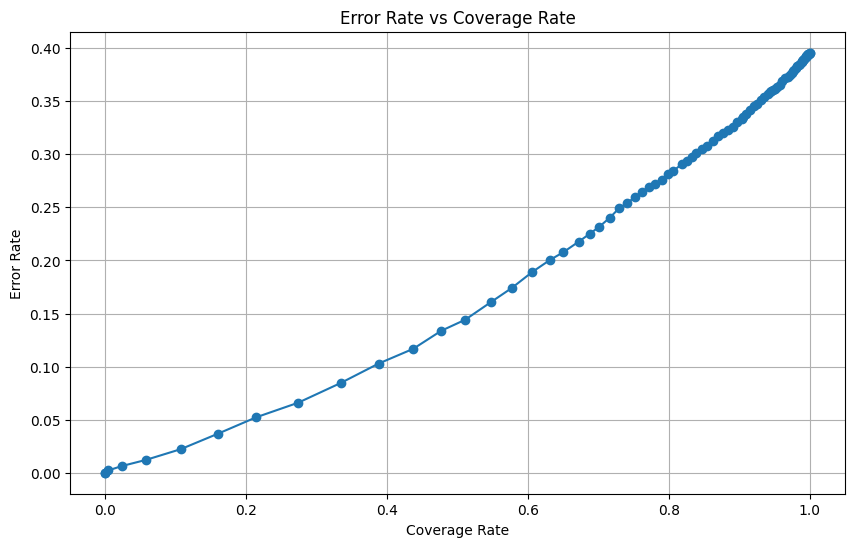

In [28]:
# Plot the error rates
plt.figure(figsize=(10, 6))
plt.plot(list(error_rate_dict.keys()), list(error_rate_dict.values()), marker='o')
plt.title('Error Rate vs Coverage Rate')
plt.xlabel('Coverage Rate')
plt.ylabel('Error Rate')
plt.grid()
plt.show()

## Task 4

In [84]:
# your solution
# datasets: first 10 classes of train_dataset and main_test_dataset

# reload the model from the previous task
model = EmbeddingFashionCNN(embedding_dim=39)
model.load_state_dict(torch.load("task_2.pth"))
model.to(device)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)

#extract embeddings
embeddings = []
labels = []
for image, label in train_loader:
    if label[0] in range(10):
        image = image.to(device)
        with torch.no_grad():
            embeddings.append(model(image).cpu())
            labels.append(label[0].cpu())

main_test_loader = DataLoader(main_test_dataset, batch_size=1, shuffle=False)

for image, label in main_test_loader:
    if label[0] in range(10):
        image = image.to(device)
        with torch.no_grad():
            embeddings.append(model(image).cpu())
            labels.append(label[0].cpu())

# apply PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
train_embeddings_10_pca = pca.fit_transform(torch.cat(embeddings).numpy())


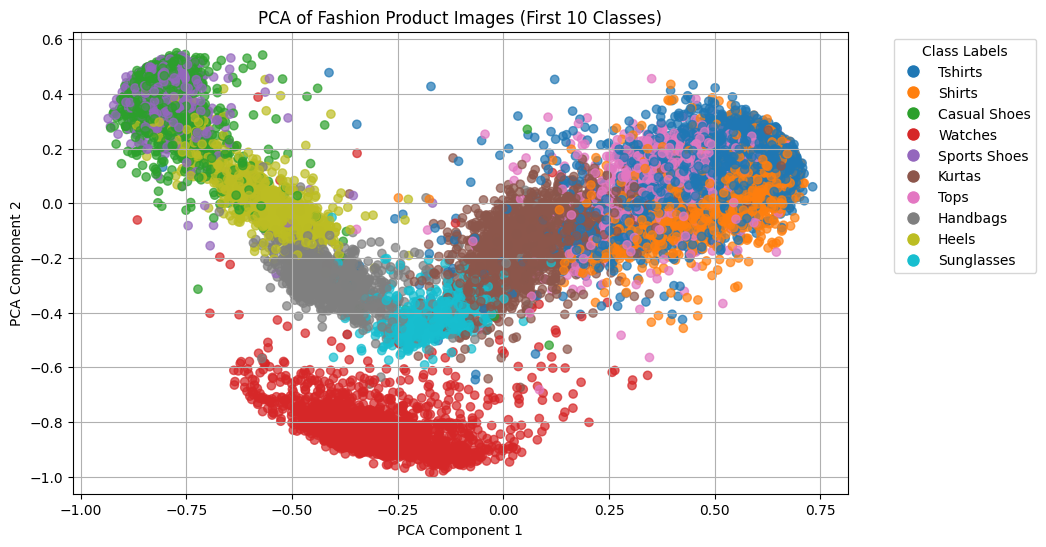

In [85]:
from matplotlib.colors import ListedColormap

# Define a categorical colormap
cmap = ListedColormap(plt.cm.tab10.colors[:10])  # Use the first 10 colors from the tab10 colormap

# Plot the PCA
plt.figure(figsize=(10, 6))
scatter = plt.scatter(train_embeddings_10_pca[:, 0], train_embeddings_10_pca[:, 1], c=labels, cmap=cmap, alpha=0.7)

# Add a legend with label names
legend_labels = [label_id_to_label_name[i] for i in range(10)]
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i), markersize=10) for i in range(10)]
plt.legend(handles, legend_labels, title="Class Labels", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('PCA of Fashion Product Images (First 10 Classes)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid()
plt.show()

In [ ]:
# create a confusion matrix with the first 10 classes over main_test_dataset and main_support_dataset
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

test_loader_main_test = DataLoader(main_test_dataset, batch_size=1, shuffle=False)
support_loader_main_train = DataLoader(train_dataset, batch_size=1, shuffle=False)

# Extract embeddings
test_embeddings_main_test = []
test_labels_main_test = []
for image, label in test_loader_main_test:
    if label[0] in range(10):
        image = image.to(device)
        with torch.no_grad():
            test_embeddings_main_test.append(model(image).cpu())
            test_labels_main_test.append(label[0].cpu())

support_embeddings_main_train = []
support_labels_main_train = []
for image, label in support_loader_main_train:
    if label[0] in range(10):
        image = image.to(device)
        with torch.no_grad():
            support_embeddings_main_train.append(model(image).cpu())
            support_labels_main_train.append(label[0].cpu())



TypeError: cdist(): argument 'x1' (position 1) must be Tensor, not list

C:\Users\Admin\AppData\Local\Temp\ipykernel_6552\1012706623.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  knn_labels = torch.tensor(support_labels_main_train)[knn_indices]


Predicted labels: [1, 6, 6, 0, 0, 2, 1, 8, 5, 0, 1, 1, 2, 0, 2, 0, 3, 5, 3, 0, 0, 7, 0, 1, 6, 7, 2, 0, 8, 3, 0, 0, 1, 5, 1, 4, 7, 2, 2, 0, 0, 1, 6, 8, 8, 0, 4, 1, 3, 4, 3, 4, 2, 7, 8, 0, 0, 2, 0, 2, 1, 5, 8, 0, 6, 3, 7, 2, 6, 1, 0, 0, 0, 0, 3, 6, 6, 4, 3, 6, 3, 1, 0, 4, 2, 0, 7, 6, 2, 0, 0, 0, 4, 3, 0, 3, 1, 4, 5, 1, 0, 2, 1, 5, 6, 6, 0, 1, 0, 6, 3, 1, 0, 1, 4, 1, 0, 1, 0, 8, 0, 7, 0, 1, 4, 1, 2, 1, 0, 7, 7, 0, 3, 4, 2, 2, 0, 2, 1, 3, 2, 1, 0, 5, 1, 2, 3, 3, 9, 7, 2, 3, 3, 7, 5, 1, 0, 3, 6, 0, 0, 5, 0, 1, 2, 2, 0, 0, 6, 0, 3, 4, 2, 4, 3, 1, 2, 5, 0, 6, 2, 9, 8, 1, 0, 8, 0, 3, 1, 0, 0, 0, 3, 7, 1, 2, 2, 0, 0, 0, 4, 8, 1, 4, 3, 3, 9, 0, 4, 3, 0, 6, 0, 7, 1, 2, 0, 1, 0, 0, 0, 4, 1, 7, 0, 4, 4, 0, 6, 3, 1, 0, 5, 2, 4, 0, 0, 0, 0, 7, 0, 4, 5, 6, 4, 6, 6, 1, 5, 0, 2, 3, 5, 2, 0, 1, 5, 9, 3, 4, 1, 0, 1, 1, 2, 1, 0, 1, 0, 6, 4, 3, 8, 0, 0, 2, 2, 0, 0, 4, 1, 1, 0, 5, 0, 0, 0, 2, 1, 3, 3, 3, 0, 0, 1, 1, 6, 0, 1, 5, 2, 5, 3, 7, 1, 3, 6, 4, 0, 0, 0, 8, 0, 7, 5, 0, 2, 9, 0, 3, 0, 2, 8, 6, 0, 5, 0, 

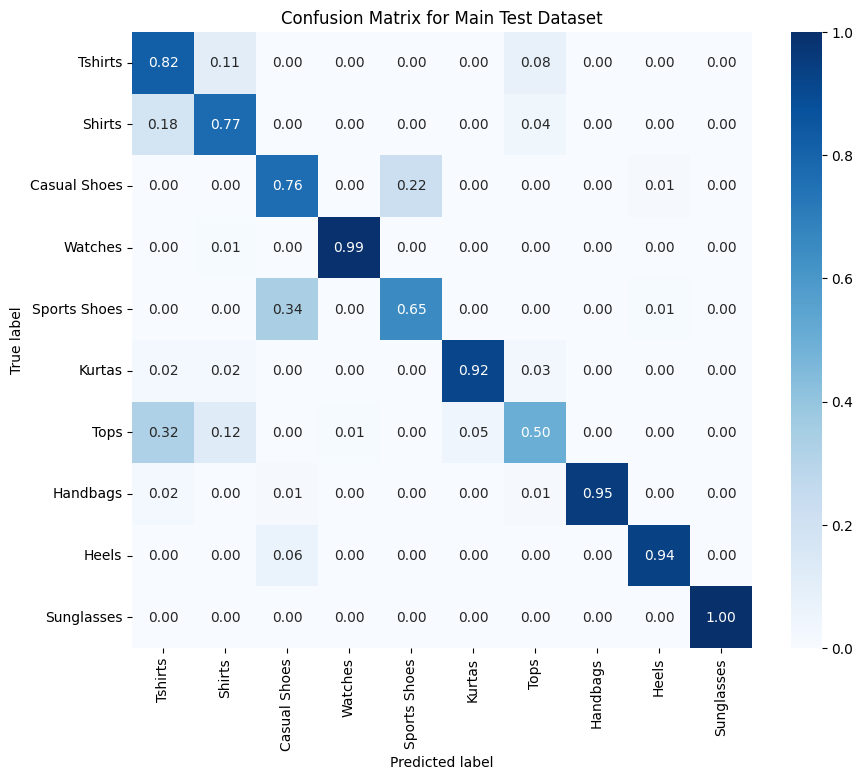

In [109]:
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    cm = confusion_matrix(
        y_true, y_pred, labels=classes
    )

    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=[label_id_to_label_name[i] for i in classes], 
                yticklabels=[label_id_to_label_name[i] for i in classes])
    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

pred_labels = []
for test_embedding in test_embeddings_main_test:
    distances = torch.cdist(test_embedding.unsqueeze(0), support_embeddings_main_train)
    knn_indices = distances.topk(3, largest=False, dim=0).indices[0]  # Get indices of 3 nearest neighbors
    knn_labels = torch.tensor(support_labels_main_train)[knn_indices]
    predicted_label = torch.mode(knn_labels).values
    pred_labels.append(predicted_label.item())

print(f"Predicted labels: {pred_labels}")

plot_confusion_matrix(test_labels_main_test, pred_labels, classes=range(10), title='Confusion Matrix for Main Test Dataset')

In [185]:
class FashionDataset_with_embeddings():
    """
    A dataset class that returns the image and its corresponding embedding.
    """
    def __init__(self, model):
        self.model = model
        self.dataset1 = FashionDataset("dataset/train.csv", img_dir, transform=transform)
        self.dataset2 = FashionDataset("dataset/main_test.csv", img_dir, transform=transform)

    def __len__(self):
        return len(self.dataset1) + len(self.dataset2)
    
    def __getitem__(self, idx):
        if idx < len(self.dataset1):
            image, label = self.dataset1[idx]
        else:
            image, label = self.dataset2[idx - len(self.dataset1)]
        
        # Get the embedding
        with torch.no_grad():
            embedding = self.model(image.unsqueeze(0).to(device)).cpu().squeeze(0)
        
        return image, label, embedding
    
    def get_embeddings(self):
        """
        Get all embeddings from the dataset.
        """
        all_embeddings = []
        all_labels = []

        for i in range(len(self)):
            image, label, embedding = self[i]
            all_embeddings.append(embedding)
            all_labels.append(label)

        return torch.stack(all_embeddings), torch.tensor(all_labels)

def find_closest_sample(coordinate, all_embeddings):
    """
    Find the index of the closest sample to the given coordinate in the embedding space.
    """
    distances = torch.norm(all_embeddings - coordinate, dim=1)
    closest_index = torch.argmin(distances)
    return closest_index.item()

def get_n_samples_between_two_centroids(centroid1, centroid2, all_embeddings, n=5):
    """
    Get n samples between two centroids in the embedding space.
    """
    current_coordinate = centroid1
    step_vector = (centroid2 - centroid1) / n
    samples = []

    for i in range(n):
        #find the index of the closest sample to the current coordinate
        closest_index = find_closest_sample(current_coordinate, all_embeddings)
        samples.append(closest_index)

        current_coordinate += step_vector
    
    return samples


# Create the dataset with embeddings
dataset_with_embeddings = FashionDataset_with_embeddings(model)
train_loader = DataLoader(dataset_with_embeddings, batch_size=1, shuffle=False)

all_embeddings, all_labels = dataset_with_embeddings.get_embeddings()

centroid_class_0 = torch.mean(all_embeddings[all_labels == 0], dim=0)
centroid_class_1 = torch.mean(all_embeddings[all_labels == 1], dim=0)

indexes = get_n_samples_between_two_centroids(centroid_class_0, centroid_class_1, all_embeddings, n=15)



Closest sample index: 33351
Closest sample index: 26696
Closest sample index: 26696
Closest sample index: 8579
Closest sample index: 1416
Closest sample index: 28053
Closest sample index: 8266
Closest sample index: 26384
Closest sample index: 8488
Closest sample index: 30251
Closest sample index: 30251
Closest sample index: 1011
Closest sample index: 30561
Closest sample index: 30873
Closest sample index: 30873


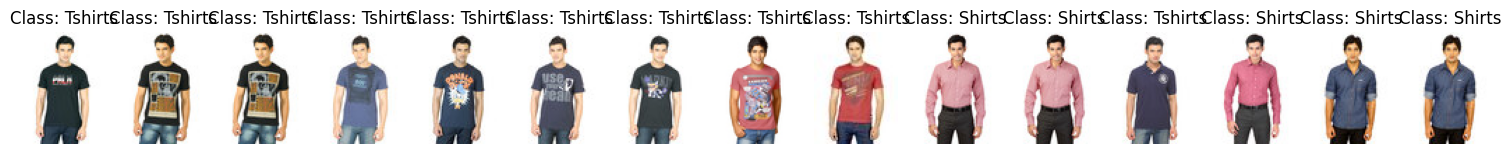

In [ ]:
fig, axes = plt.subplots(1, len(indexes), figsize=(15, 5))
for ax, i in zip(axes, indexes):
    print(f"Closest sample index: {i}")
    dataset_with_embeddings[i][0]
    image = Image.open(os.path.join(img_dir, f"{dataset_with_embeddings.dataset1.df.iloc[i]['imageId']}.jpg")).convert("RGB")
    ax.imshow(image)
    ax.set_title(dataset_with_embeddings.dataset1.df.iloc[i]['articleTypeName'])
    ax.axis('off')
plt.tight_layout()
plt.show()